<a href="https://colab.research.google.com/github/Bodya-collab/Veryfing-EGFR-inhibitors-IC50-Lipinskii-rule-ML-basis/blob/main/Veryfing_EGFR_inhibitors_IC50%7CLipinskii_rule%7CML_basis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Installing packages
!pip install rdkit pandas matplotlib seaborn scikit-learn
#import tools
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
#Importing CSV from ChEMBL| Error 500 on site - fetch_data.py reference
df = pd.read_csv('/content/Data/egfr_raw_data.csv')
display(df.head())
#Works


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,110221,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,100.00
1,NaN,NaN,113118,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,100.00
2,NaN,NaN,119387,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,100.00
3,NaN,NaN,133319,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,25.00
4,NaN,NaN,193384,[],CHEMBL675513,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,0.07


In [3]:
#Column list
print(df.columns.tolist())

['action_type', 'activity_comment', 'activity_id', 'activity_properties', 'assay_chembl_id', 'assay_description', 'assay_type', 'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint', 'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment', 'data_validity_description', 'document_chembl_id', 'document_journal', 'document_year', 'ligand_efficiency', 'molecule_chembl_id', 'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id', 'standard_flag', 'standard_relation', 'standard_text_value', 'standard_type', 'standard_units', 'standard_upper_value', 'standard_value', 'target_chembl_id', 'target_organism', 'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units', 'upper_value', 'value']


In [4]:
#Choosing only specified Data which we are interested in:
selected_columns = ['canonical_smiles','standard_type','standard_units','standard_value']
df_selected = df[selected_columns].copy()
df_selected = df.dropna(subset=['canonical_smiles'])
display(df_selected.head())

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,110221,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,100.00
1,NaN,NaN,113118,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,100.00
2,NaN,NaN,119387,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,100.00
3,NaN,NaN,133319,[],CHEMBL675511,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,25.00
4,NaN,NaN,193384,[],CHEMBL675513,Inhibition of epidermal growth factor receptor...,B,NaN,NaN,BAO_0000190,...,Mus musculus,Epidermal growth factor receptor,10090,NaN,NaN,IC50,uM,UO_0000065,NaN,0.07


In [5]:
# Import Descriptors for logP,MolWt,HB,HA calculation
from rdkit.Chem import Descriptors

# Function to calculate LogP from SMILES
def calculate_logp(smiles):
    if smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Descriptors.MolLogP(mol)
# Apply the function to the 'canonical_smiles' column of df_selected
df_selected['LogP'] = df_selected['canonical_smiles'].apply(calculate_logp)
#Function to calculate MolWt from SMILES
def calculate_MolWt(smiles):
  if smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
          return Descriptors.MolWt(mol)
#Apply the function to the 'canonical_smiles' column of df_selected
df_selected['MolWt'] = df_selected['canonical_smiles'].apply(calculate_MolWt)
#Function to calculate NumHDonors from SMILES
def calculate_NumHDonors(smiles):
  if smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
          return Descriptors.NumHDonors(mol)
df_selected['NumHDonors'] = df_selected['canonical_smiles'].apply(calculate_NumHDonors)
#Function to calculate NumHAcceptors from SMILES
def calculate_NumHAcceptors(smiles):
  if smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
          return Descriptors.NumHAcceptors(mol)
df_selected['NumHAcceptors'] = df_selected['canonical_smiles'].apply(calculate_NumHAcceptors)
def calculate_NumHAcceptors(smiles):
  if smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
          return Descriptors.NumHAcceptors(mol)
df_selected['NumHAcceptors'] = df_selected['canonical_smiles'].apply(calculate_NumHAcceptors)


#Applying function in order to exclude bad molecules
df_clean = df_selected.dropna(subset=['MolWt', 'LogP',])

#Data gained
final_columns = [
    'molecule_chembl_id',
    'canonical_smiles',
    'standard_value',  # value of IC50
    'MolWt',
    'LogP',
    'NumHDonors',
    'NumHAcceptors'
]
df_final = df_clean[final_columns]
print(df_final)

#Save
df_final.to_csv('egfr_lipinski_data.csv', index=False)
df_final.to_excel('egfr_lipinski_data.xlsx', index=False)

   molecule_chembl_id                                   canonical_smiles  \
0        CHEMBL292323  COc1cccc2c(C(=O)Nc3ccccc3)c(SSc3c(C(=O)Nc4cccc...   
1        CHEMBL304414  Cn1c(SSc2c(C(=O)Nc3ccccc3)c3ccccc3n2C)c(C(=O)N...   
2         CHEMBL62176                 CN1C(=S)C(C(=O)Nc2ccccc2)c2ccccc21   
3         CHEMBL62701  Cn1c(SSc2c(C(=O)Nc3ccccc3)c3cccnc3n2C)c(C(=O)N...   
4        CHEMBL137617               C/N=N/Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1   
..                ...                                                ...   
92         CHEMBL1336  CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...   
93      CHEMBL2110732  COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/C...   
94          CHEMBL939     COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1   
95          CHEMBL553         C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1   
96       CHEMBL545315  C=CC(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1OCCCN...   

    standard_value    MolWt    LogP  NumHDonors  NumHAcceptors  
0         100000.0  62

    standard_value  Activity
0         100000.0  Inactive
1         100000.0  Inactive
2         100000.0  Inactive
3          25000.0  Inactive
4             70.0    Active
..             ...       ...
92          3500.0  Inactive
93             5.8    Active
94            14.4    Active
95            19.3    Active
96             1.6    Active

[97 rows x 2 columns]


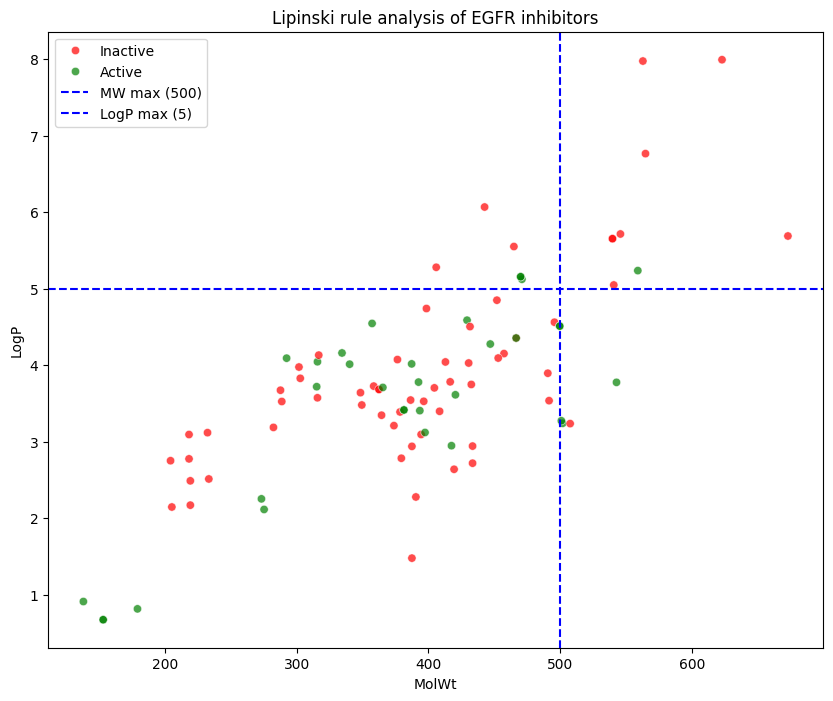

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Importing excel file with parameters: logP, MolWt, HB, HA
df = pd.read_excel('/content/Data/egfr_lipinski_data.xlsx')
#Classification's clause which devide Active  and inactive compounds:
def classify_molecule(standard_value):
  if standard_value <= 1000:
    return 'Active'
  elif standard_value >1000:
    return 'Inactive'
#Apply to all rows
df['Activity'] = df['standard_value'].apply(classify_molecule)
print(df[['standard_value','Activity']])
#Visualizing
plt.figure(figsize=(10, 8))
#Build the points; x = MolWt; y = logP; colour(pallete) = 'Activity'.
sns.scatterplot(
    data=df,
    x='MolWt',
    y='LogP',
    hue='Activity',
    palette={'Active': 'green', 'Inactive': 'red'},
    alpha=0.7 #Transparency
)
#Lipinski borders for MolWt <=500:
plt.axvline(x=500, color='blue', linestyle='--', label='MW max (500)')
#Lipinski borders for LopP <=5:
plt.axhline(y=5, color='blue', linestyle='--', label='LogP max (5)')
plt.title('Lipinski rule analysis of EGFR inhibitors')
plt.legend()
plt.grid(False)
plt.show
df.to_csv('Activity.csv', index = False)
#P.S for output: The preview shows that active EGFR inhibitors occupy a broad chemical space.
#A significant portion of the active compounds (green dots) conform to Lipinski's Five Rules .
#This suggests good potential for developing oral formulations

Accuracy 0.6666666666666666


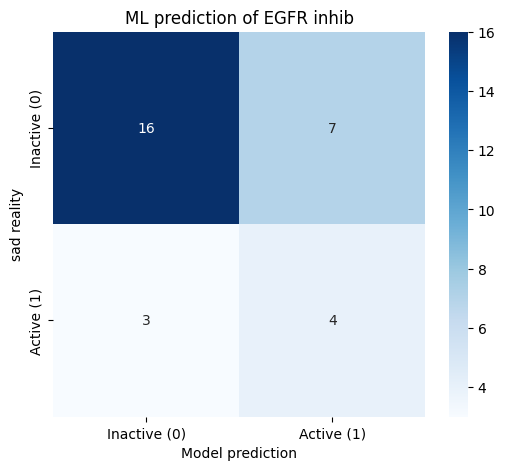

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd # Import pandas here
import matplotlib.pyplot as plt # Import matplotlib here
import seaborn as sns # Import seaborn here

df = pd.read_csv('/content/Activity.csv')

# Transforming 'Active' to 1 and 'Inactive' to 0
df['Target'] = df['Activity'].apply(lambda x: 1 if x == 'Active' else 0)

# Defining X and Y (features and target)
x = df[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']]
y = df['Target']

# Creating 2 groups: 'Train' & 'Test'. Also i dont give 30% of available info in order to verify model.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Training process:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

# Prediction
y_pred = model.predict(x_test)

# Accuracy result:
print('Accuracy', accuracy_score(y_test, y_pred))

# Confusion matrix == shows main mistakes where is the biggest difference beetween pred and test
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Inactive (0)', 'Active (1)'],
            yticklabels=['Inactive (0)', 'Active (1)'])
plt.xlabel('Model prediction')
plt.ylabel('sad reality')
plt.title('ML prediction of EGFR inhib')
plt.show()

It is for ML which were trained for specific points in a compound.

Accuracy 0.6666666666666666


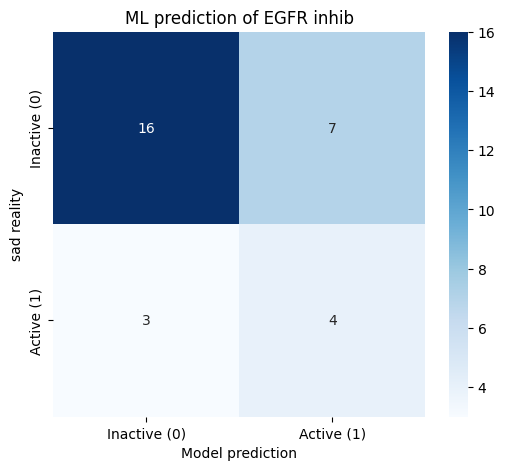

In [13]:
df = pd.read_csv('/content/Activity.csv')

# Transforming 'Active' to 1 and 'Inactive' to 0
df['Target'] = df['Activity'].apply(lambda x: 1 if x == 'Active' else 0)

# Defining X and Y (features and target)
x = df[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']]
y = df['Target']

# Creating 2 groups: 'Train' & 'Test'. Also i dont give 30% of available info in order to verify model.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Training process:                                                         (balanced part)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(x_train, y_train)

# Prediction
y_pred = model.predict(x_test)

# Accuracy result:
print('Accuracy', accuracy_score(y_test, y_pred))

# Confusion matrix == shows main mistakes where is the biggest difference beetween pred and test
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Inactive (0)', 'Active (1)'],
            yticklabels=['Inactive (0)', 'Active (1)'])
plt.xlabel('Model prediction')
plt.ylabel('sad reality')
plt.title('ML prediction of EGFR inhib')
plt.show()